<a href="https://colab.research.google.com/github/fluderm/PyBulletPerAct/blob/main/Create_and_save_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Save demo from Panda (compatible with RLBench and PyBulletPerAct):** 

In this notebook we implement methods to save PyBullet/panda_gym simulation demos in accordance with [`YARR`](https://github.com/stepjam/YARR), [`RLBench`](https://github.com/stepjam/RLBench) and importantly in accordance with [PyBulletPerAct](https://github.com/fellowship/Robotics-Simulator-Imitation-Learning/blob/main/PyBulletPerAct.ipynb).

You should be able to generate simple demos for various tasks and save them in such a way that it feeds straightforwardly into the PyBulletPerAct training pipeline.


### Install Dependencies

In [ ]:
%pip install setuptools==65.5.0 # Need to add this for panda-gym==2.0.0 to work
!apt install -y python-opengl ffmpeg > /dev/null 2>&1
%pip install pyvirtualdisplay

#stable_baselines3 sb3_contrib panda-gym==2.0.0 
!pip install pyvirtualdisplay 
!apt install xvfb python-opengl ffmpeg

### Clone Repo and Setup

This repo contains barebones code from [`panda_gym`](https://github.com/qgallouedec/panda-gym).


In [ ]:
!git clone https://github.com/fluderm/PyBulletPerAct.git
%pip install -e PyBulletPerAct

# copy glass files to current directory:

!cp PyBulletPerAct/panda_gym/plastic_coffee_cup.mtl \
 PyBulletPerAct/panda_gym/plastic_coffee_cup_vhacd.obj \
 PyBulletPerAct/panda_gym/plastic_coffee_cup.obj .

# Panda Gym

In [ ]:
import sys

sys.path.append('PyBulletPerAct')


In [ ]:
import gym

import panda_gym
import pprint
import numpy as np
import pybullet as p
import math

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1024, 768))
display.start()

from matplotlib import pyplot as plt, animation
%matplotlib inline
from IPython import display

'''
The following are some basic functions that help render the virtual PyBullet
environment:
'''


def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)


class trigger:
    def __init__(self):
        self._trigger = True

    def __call__(self, e):
        return self._trigger

    def set(self, t):
        self._trigger = t

Quick test if everything works:

The relevant environment is stored under PandaPickAndPlace-v2. One can of course rename this environment (need to register inside panda_gym '__init__' file).

In [ ]:
#env.close()
env = gym.make('PandaPickAndPlace-v2',control_type='joints')
obs = env.reset()
env.robot.neutral_joint_values = np.array([0.00, 0.41, 0.00, -1.85, 3.14, 2.52, 0.79, 3.00, 3.00])
print(obs)

rgb, depth, mask, misc = env.render(mode = 'rgb_array')
display.HTML(display_anim([rgb['front']]))

In [ ]:
obs = env.reset()

# enable joint force sensor:
[(env.sim.physics_client.enableJointForceTorqueSensor(0,i)) for i in range(11)];

# Save panda dataset

## Some Utils

In [ ]:
import datetime as dt
from time import sleep

def no_disconnect():
  '''
  function that ensures Colab pro doesn't disconnect.
  '''
  t = dt.datetime.now()

  while True:
      delta = dt.datetime.now()-t               
      if delta.seconds >= 60:
          print("1 Min",dt.datetime.now())
          t = dt.datetime.now()
      sleep(10)

In [ ]:
def _normalize(pc):
  return (pc - np.amin(pc)) / (np.amax(pc) - np.amin(pc))

In [ ]:
#from multiprocessing import Process, Manager
import sys

sys.path.append('peract_colab')

import os
import pickle
from PIL import Image
import numpy as np

#from absl import app
#from absl import flags

In [ ]:
panda_dataset_dir = 'PyBulletPerAct/data'

def check_and_make(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

check_and_make(panda_dataset_dir)

In [ ]:
def ClipFloatValues(float_array, min_value, max_value):
  '''
  Clips values to the range [min_value, max_value].
  First checks if any values are out of range and prints a message.
  Then clips all values to the given range.
  Args:
    float_array: 2D array of floating point values to be clipped.
    min_value: Minimum value of clip range.
    max_value: Maximum value of clip range.
  Returns:
    The clipped array.
  '''
  if float_array.min() < min_value or float_array.max() > max_value:
    float_array = np.clip(float_array, min_value, max_value)
  return float_array

DEFAULT_RGB_SCALE_FACTOR = 256000.0

def float_array_to_rgb_image(float_array,
                             scale_factor=DEFAULT_RGB_SCALE_FACTOR,
                             drop_blue=False):
  '''
  Convert a floating point array of values to an RGB image.
  Convert floating point values to a fixed point representation where
  the RGB bytes represent a 24-bit integer.
  R is the high order byte.
  B is the low order byte.
  The precision of the depth image is 1/256 mm.
  Floating point values are scaled so that the integer values cover
  the representable range of depths.
  This image representation should only use lossless compression.
  Args:
    float_array: Input array of floating point depth values in meters.
    scale_factor: Scale value applied to all float values.
    drop_blue: Zero out the blue channel to improve compression, results in 1mm
      precision depth values.
  Returns:
    24-bit RGB PIL Image object representing depth values.
  '''
  # Scale the floating point array.
  scaled_array = np.floor(float_array * scale_factor + 0.5)

  # Convert the array to integer type and clip to representable range.
  min_inttype = 0
  max_inttype = 2**24 - 1
  scaled_array = ClipFloatValues(scaled_array, min_inttype, max_inttype)
  int_array = scaled_array.astype(np.uint32)
  # Calculate:
  #   r = (f / 256) / 256  high byte
  #   g = (f / 256) % 256  middle byte
  #   b = f % 256          low byte
  rg = np.divide(int_array, 256)
  r = np.divide(rg, 256)
  g = np.mod(rg, 256)
  image_shape = int_array.shape
  rgb_array = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)
  rgb_array[..., 0] = r
  rgb_array[..., 1] = g
  if not drop_blue:
    # Calculate the blue channel and add it to the array.
    b = np.mod(int_array, 256)
    rgb_array[..., 2] = b
  image_mode = 'RGB'
  image = Image.fromarray(rgb_array, mode=image_mode)
  return image

In [ ]:
# Within PyBullet can also do p.getMatrixFromQuaternion(com_o)

def rotationMatrixToEulerAngles(R) :
    '''
    function that transforms rotation 3x3 matrix to Euler angles:
    '''
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])


In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as Rot

def cvK2BulletP(K, w, h, near, far):
    '''
    cvKtoPulletP converts the K interinsic matrix as calibrated using Opencv
    and ROS to the projection matrix used in openGL and Pybullet.

    :param K:  OpenCV 3x3 camera intrinsic matrix
    :param w:  Image width
    :param h:  Image height
    :near:     The nearest objects to be included in the render
    :far:      The furthest objects to be included in the render
    :return:   4x4 projection matrix as used in openGL and pybullet
    '''
    f_x = K[0,0]
    f_y = K[1,1]
    c_x = K[0,2]
    c_y = K[1,2]
    A = (near + far)/(near - far)
    B = 2 * near * far / (near - far)

    projection_matrix = [
                        [2/w * f_x,  0,          (w - 2*c_x)/w,  0],
                        [0,          2/h * f_y,  (2*c_y - h)/h,  0],
                        [0,          0,          A,              B],
                        [0,          0,          -1,             0]]
    # The transpose is needed for respecting the array structure of the PyB
    # and OpenGL
    return np.array(projection_matrix).T.reshape(16).tolist()

def BulletP2cvK(proj_mat, w, h):
    '''
    inverse of above cvK2BulletP function
    '''
    A,B = proj_mat[2,2],proj_mat[3,2]
    n,f = B/(A-1), B/(A+1)
    fx,fy = w*proj_mat[0,0]/2,h*proj_mat[1,1]/2
    cx,cy = w*(1-proj_mat[2,0])/2, h*(proj_mat[2,1]+1)/2

    return np.array([[fx,0,cx],[0,fy,cy],[0,0,1]]), n, f


def cvPose2BulletView(Rt):
    '''
    cvPose2BulletView gets orientation and position as used 
    in ROS-TF and opencv and coverts it to the view matrix used 
    in openGL and pyBullet.
    
    :param Rt: 4x4 extrinsic matrix
    :return:  4x4 view matrix as used in PyBullet and openGL
    
    '''

    Tc = np.array([[1,   0,    0,  0],
                   [0,  -1,    0,  0],
                   [0,   0,   -1,  0],
                   [0,   0,    0,  1]]).reshape(4,4)
    
    # pybullet pse is the inverse of the pose from the ROS-TF
    T=Tc@np.linalg.inv(Rt)
    # The transpose is needed for respecting the array structure of the OpenGL
    viewMatrix = T.T.reshape(16)
    return viewMatrix

def BullettocvPose(X):
    '''
    Inverse function of cvPose2BulletView, i.e. returns extrinsic matrix from
    PyBullet/OpenGL.
    '''
    Tc = np.array([[1,   0,    0,  0],
                   [0,  -1,    0,  0],
                   [0,   0,   -1,  0],
                   [0,   0,    0,  1]]).reshape(4,4)
    
    T = np.linalg.inv(X.T)@Tc
    
    return T


## Create Demo

### Define classes

Define observation and demo classes as per the conventions of [`YARR`](https://github.com/stepjam/YARR) and [`RLBench`](https://github.com/stepjam/RLBench). This is where we store observations/demos.

In [ ]:
class Demo(object):

    def __init__(self, observations, random_seed=None):
        self._observations = observations
        self.random_seed = random_seed
        self.variation_number = 0

    def __len__(self):
        return len(self._observations)

    def __getitem__(self, i):
        return self._observations[i]

    def restore_state(self):
        np.random.set_state(self.random_seed)

In [ ]:
class Observation(object):
    """Storage for both visual and low-dimensional observations."""

    def __init__(self,
                 left_shoulder_rgb: np.ndarray,
                 left_shoulder_depth: np.ndarray,
                 left_shoulder_mask: np.ndarray,
                 left_shoulder_point_cloud: np.ndarray,
                 right_shoulder_rgb: np.ndarray,
                 right_shoulder_depth: np.ndarray,
                 right_shoulder_mask: np.ndarray,
                 right_shoulder_point_cloud: np.ndarray,
                 overhead_rgb: np.ndarray,
                 overhead_depth: np.ndarray,
                 overhead_mask: np.ndarray,
                 overhead_point_cloud: np.ndarray,
                 wrist_rgb: np.ndarray,
                 wrist_depth: np.ndarray,
                 wrist_mask: np.ndarray,
                 wrist_point_cloud: np.ndarray,
                 front_rgb: np.ndarray,
                 front_depth: np.ndarray,
                 front_mask: np.ndarray,
                 front_point_cloud: np.ndarray,
                 joint_velocities: np.ndarray,
                 joint_positions: np.ndarray,
                 joint_forces: np.ndarray,
                 gripper_open: float,
                 gripper_pose: np.ndarray,
                 gripper_matrix: np.ndarray,
                 gripper_joint_positions: np.ndarray,
                 gripper_touch_forces: np.ndarray,
                 task_low_dim_state: np.ndarray,
                 ignore_collisions: np.ndarray,
                 misc: dict):
        self.left_shoulder_rgb = left_shoulder_rgb
        self.left_shoulder_depth = left_shoulder_depth
        self.left_shoulder_mask = left_shoulder_mask
        self.left_shoulder_point_cloud = left_shoulder_point_cloud
        self.right_shoulder_rgb = right_shoulder_rgb
        self.right_shoulder_depth = right_shoulder_depth
        self.right_shoulder_mask = right_shoulder_mask
        self.right_shoulder_point_cloud = right_shoulder_point_cloud
        self.overhead_rgb = overhead_rgb
        self.overhead_depth = overhead_depth
        self.overhead_mask = overhead_mask
        self.overhead_point_cloud = overhead_point_cloud
        self.wrist_rgb = wrist_rgb
        self.wrist_depth = wrist_depth
        self.wrist_mask = wrist_mask
        self.wrist_point_cloud = wrist_point_cloud
        self.front_rgb = front_rgb
        self.front_depth = front_depth
        self.front_mask = front_mask
        self.front_point_cloud = front_point_cloud
        self.joint_velocities = joint_velocities
        self.joint_positions = joint_positions
        self.joint_forces = joint_forces
        self.gripper_open = gripper_open
        self.gripper_pose = gripper_pose
        self.gripper_matrix = gripper_matrix
        self.gripper_joint_positions = gripper_joint_positions
        self.gripper_touch_forces = gripper_touch_forces
        self.task_low_dim_state = task_low_dim_state
        self.ignore_collisions = ignore_collisions
        self.misc = misc

In [ ]:
from typing import Type

class ObservationElement(object):

    def __init__(self, name: str, shape: tuple, type: Type[np.dtype]):
        self.name = name
        self.shape = shape
        self.type = type

### Get Obs:

We now define a function that saves the observation from panda_gym/PyBullet in accordance with [rlbench](https://github.com/stepjam/RLBench), [PerAct](https://github.com/peract/peract) and specifically the PyBulletPerAct colab file.

Not everything implemented here is actually used in PyBulletPerAct but it is in accordance with the RLBench conventions.

In [ ]:
def _normalize_fn(pc,far,near):
  '''
  helper "normalization" function for depth
  '''
  return (pc-near)/(far-near)

In [ ]:
# env has to be initialized:

def get_observation(env) -> Observation:
    '''
    Function that extracts from panda_gym/PyBullet the data 
    (for RLbench conventions) at a specific time-step. One needs to be careful
    to change conventions from PyBullet to RLBench.
    '''

    _sim_pc = env.sim.physics_client
    _sim = env.sim
    panda_id = _sim._bodies_idx['panda']

    pos = np.array([_sim_pc.getJointState(panda_id,i)[0] \
            for i in range(7)])
    vels = np.array([_sim_pc.getJointState(panda_id,i)[1] \
            for i in range(7)])
    joint_forces = np.array([_sim_pc.getJointState(panda_id,i)[3] \
                    for i in range(7)])
    
    ee_forces_flat = np.array(_sim_pc.getJointState(panda_id,6)[2])

    rgb, depth, mask, cam_misc = env.render(mode = 'rgb_array')

    left_shoulder_rgb = rgb['left_shoulder']
    # adjust depth conventions:
    far = cam_misc['left_shoulder']['far']
    near = cam_misc['left_shoulder']['near']
    left_shoulder_depth = (far*near)/(far-(far-near)*depth['left_shoulder'])
    # scale to be in [0,1]:
    left_shoulder_depth = _normalize_fn(left_shoulder_depth,far,near)
    # (Mask is not necessary for PyBulletPerAct)
    left_shoulder_mask = mask['left_shoulder']

    right_shoulder_rgb = rgb['right_shoulder']
    # adjust depth conventions:
    far = cam_misc['right_shoulder']['far']
    near = cam_misc['right_shoulder']['near']
    right_shoulder_depth = (far*near)/(far-(far-near)*depth['right_shoulder'])
    # scale to be in [0,1]:
    right_shoulder_depth = _normalize_fn(right_shoulder_depth,far,near)
    # (Mask is not necessary for PyBulletPerAct)
    right_shoulder_mask = mask['right_shoulder']

    # if you want more camera angles follow the above formate
    # overhead_rgb = ...
    # overhead_depth = ...
    # overhead_mask = ...

    wrist_rgb = rgb['wrist']
    # adjust depth conventions:
    far = cam_misc['wrist']['far']
    near = cam_misc['wrist']['near']
    wrist_depth = (far*near)/(far-(far-near)*depth['wrist'])
    # scale to be in [0,1]:
    wrist_depth = _normalize_fn(wrist_depth,far,near)
    # (Mask is not necessary for PyBulletPerAct)
    wrist_mask = mask['wrist']
    
    front_rgb = rgb['front']
    # adjust depth conventions:
    far = cam_misc['front']['far']
    near = cam_misc['front']['near']
    front_depth = (far*near)/(far-(far-near)*depth['front'])
    # scale to be in [0,1]:
    front_depth = _normalize_fn(front_depth,far,near)
    # (Mask is not necessary for PyBulletPerAct)
    front_mask = mask['front']

    gripper_state = _sim_pc.getLinkState(0,11)
    gripper_pose = np.concatenate(gripper_state[:2])

    gripper_rot_mat = np.array(_sim_pc.getMatrixFromQuaternion(gripper_state[1])).reshape(-1,3)
    gripper_matrix = np.row_stack((np.column_stack((gripper_rot_mat,gripper_pose[:3])),np.array([0,0,0,1])))

    gripper_joint_pos = np.array([_sim_pc.getJointState(0, i)[0] for i in range(9,11)])

    glass_id = _sim._bodies_idx['object']
    cp9_glass = len(_sim_pc.getContactPoints(panda_id,glass_id, linkIndexA = 9))
    cp10_glass = len(_sim_pc.getContactPoints(panda_id,glass_id, linkIndexA = 10))
    ignore_collisions = np.array(1 if (cp9_glass>0 and cp10_glass>0) else 0)

    gripper_op = (1 if env.robot.get_fingers_width() > 0.09 else 0)
    cp9 = len(_sim_pc.getContactPoints(bodyA = panda_id, linkIndexA = 9))
    cp10 = len(_sim_pc.getContactPoints(bodyA = panda_id, linkIndexA = 9))
    gripper_with_obj = (1 if (cp9==0 and cp10==0) else 0)

    gripper_open = (1.0 if (gripper_op==1 and gripper_with_obj==1) else 0)

    obs = Observation(
        left_shoulder_rgb=left_shoulder_rgb,
        left_shoulder_depth=left_shoulder_depth,
        left_shoulder_point_cloud = None,
        right_shoulder_rgb=right_shoulder_rgb,
        right_shoulder_depth=right_shoulder_depth,
        right_shoulder_point_cloud= None,
        overhead_rgb = None, #overhead_rgb,
        overhead_depth = None, #overhead_depth,
        overhead_point_cloud = None, #overhead_pcd,
        wrist_rgb=wrist_rgb,
        wrist_depth=wrist_depth,
        wrist_point_cloud = None,
        front_rgb=front_rgb,
        front_depth=front_depth,
        front_point_cloud=None,
        left_shoulder_mask=left_shoulder_mask,
        right_shoulder_mask=right_shoulder_mask,
        overhead_mask= None, #overhead_mask,
        wrist_mask = wrist_mask,
        front_mask = front_mask,
        joint_velocities = vels,
        joint_positions = pos,
        joint_forces = joint_forces,
        gripper_open = gripper_open, 
        gripper_pose = gripper_pose,
        gripper_matrix = gripper_matrix,
        gripper_touch_forces = ee_forces_flat,
        gripper_joint_positions = gripper_joint_pos,
        task_low_dim_state = get_low_dim_state(env),
        ignore_collisions = ignore_collisions, # get correct object
        misc=_get_misc(cam_misc))
    return obs


def get_low_dim_state(env) -> np.ndarray:
    """
    Gets the pose and various other properties of objects in the task.
    :return: 1D array of low-dimensional task state.

    This needs some modifications if one wants to use this notebook
    for tasks beyond PerAct.
    """

    # Corner cases:
    # (1) Object has been deleted.
    # (2) Object has been grasped (and is now child of gripper).

    state = []
    '''
    for obj, objtype in self._initial_objs_in_scene:
        if not obj.still_exists():
            # It has been deleted
            empty_len = 7
            if objtype == ObjectType.JOINT:
                empty_len += 1
            elif objtype == ObjectType.FORCE_SENSOR:
                empty_len += 6
            state.extend(np.zeros((empty_len,)).tolist())
        else:
            state.extend(np.array(obj.get_pose()))
            if obj.get_type() == ObjectType.JOINT:
                state.extend([Joint(obj.get_handle()).get_joint_position()])
            elif obj.get_type() == ObjectType.FORCE_SENSOR:
                forces, torques = ForceSensor(obj.get_handle()).read()
                state.extend(forces + torques)
    '''
    # might include panda also, not sure -- don't think it matters.
    for obj in env.sim._bodies_idx.keys():
      if obj=='panda':
        continue
      else:
        state.extend(np.array(get_pose(env,obj)))

    return np.array(state).flatten()

def get_pose(env,body) -> np.ndarray:
    '''
    Retrieves the position and quaternion of an object
    :body: body of which we want the pose.
    :return: An array containing the (X,Y,Z,Qx,Qy,Qz,Qw) pose of
        the object.
    '''
    position,quaternion = env.sim.physics_client.getBasePositionAndOrientation(env.sim._bodies_idx[body])
    return np.r_[position, quaternion]


def _get_misc(misc_cam):
    '''
    :misc_cam: return function from render (a dictionary)
    :returns: reformatted misc data (intr/extr/near/far) as a dictionary
    '''

    def _get_cam_data(misc_cam,name):
        mc = misc_cam[name]
        w,h = mc['width'], mc['height']
        extrinsic = BullettocvPose(mc['view'])
        intrinsic = BulletP2cvK(mc['proj'], w, h)[0]
        
        d = {
            '%s_camera_extrinsics' % name: extrinsic,
            '%s_camera_intrinsics' % name: intrinsic,
            '%s_camera_near' % name: mc['near'],
            '%s_camera_far' % name: mc['far'],
        }
        return d
    misc = _get_cam_data(misc_cam, 'left_shoulder')
    misc.update(_get_cam_data(misc_cam, 'right_shoulder'))
    #misc.update(_get_cam_data(self._cam_overhead, 'overhead_camera'))
    misc.update(_get_cam_data(misc_cam, 'front'))
    misc.update(_get_cam_data(misc_cam, 'wrist'))
    return misc

## Save Demo

We now implement basic functions that saves the demo in a way that feeds straightforwardly into the PyBulletPerAct colab file.

**Rmk:** We do not implement variation number and variation description here. It is easy to modify the below function and add this if you want to save text prompts with your demos. I.e. simply save a pickle file as VARIATION_DESCRIPTIONS_PKL and uncomment the relevant lines in the PyBulletPerAct "fill_replay" function. I suggest you do this right away to simplify the pipeline..


In [ ]:
IMAGE_FORMAT = '%d.png'

LEFT_SHOULDER_RGB_FOLDER = 'left_shoulder_rgb'
LEFT_SHOULDER_DEPTH_FOLDER = 'left_shoulder_depth'
LEFT_SHOULDER_MASK_FOLDER = 'left_shoulder_mask'
RIGHT_SHOULDER_RGB_FOLDER = 'right_shoulder_rgb'
RIGHT_SHOULDER_DEPTH_FOLDER = 'right_shoulder_depth'
RIGHT_SHOULDER_MASK_FOLDER = 'right_shoulder_mask'
OVERHEAD_RGB_FOLDER = 'overhead_rgb'
OVERHEAD_DEPTH_FOLDER = 'overhead_depth'
OVERHEAD_MASK_FOLDER = 'overhead_mask'
WRIST_RGB_FOLDER = 'wrist_rgb'
WRIST_DEPTH_FOLDER = 'wrist_depth'
WRIST_MASK_FOLDER = 'wrist_mask'
FRONT_RGB_FOLDER = 'front_rgb'
FRONT_DEPTH_FOLDER = 'front_depth'
FRONT_MASK_FOLDER = 'front_mask'
EPISODES_FOLDER = 'episodes'
EPISODE_FOLDER = 'episode%d'
VARIATIONS_FOLDER = 'variation%d'

LOW_DIM_PICKLE = 'low_dim_obs.pkl'
VARIATION_DESCRIPTIONS = 'variation_descriptions.pkl'

DEPTH_SCALE = 2**24 - 1

In [ ]:
def save_demo(demo, example_path):
    '''
    Function that saves a demo (demo) (generated by using save_observation as well as
    observation and demo classes defined above) to a certain example_path 
    (e.g. on your google drive).

    The way this is saved will allow for feeding the data into the PyBulletPerAct
    colab file.
    '''
    # Save image data first, and then None the image data, and pickle
    left_shoulder_rgb_path = os.path.join(
        example_path, LEFT_SHOULDER_RGB_FOLDER)
    left_shoulder_depth_path = os.path.join(
        example_path, LEFT_SHOULDER_DEPTH_FOLDER)
    left_shoulder_mask_path = os.path.join(
        example_path, LEFT_SHOULDER_MASK_FOLDER)
    right_shoulder_rgb_path = os.path.join(
        example_path, RIGHT_SHOULDER_RGB_FOLDER)
    right_shoulder_depth_path = os.path.join(
        example_path, RIGHT_SHOULDER_DEPTH_FOLDER)
    right_shoulder_mask_path = os.path.join(
        example_path, RIGHT_SHOULDER_MASK_FOLDER)
    # you can add other camera angles such as overhead (this won't natively be
    # used in PyBulletPerAct but can easily be implemented. The upshot is that 
    # the voxelization might improve):
    # overhead_rgb_path = os.path.join(
    #    example_path, OVERHEAD_RGB_FOLDER)
    # overhead_depth_path = os.path.join(
    #    example_path, OVERHEAD_DEPTH_FOLDER)
    # overhead_mask_path = os.path.join(
    #    example_path, OVERHEAD_MASK_FOLDER)
    wrist_rgb_path = os.path.join(example_path, WRIST_RGB_FOLDER)
    wrist_depth_path = os.path.join(example_path, WRIST_DEPTH_FOLDER)
    wrist_mask_path = os.path.join(example_path, WRIST_MASK_FOLDER)
    front_rgb_path = os.path.join(example_path, FRONT_RGB_FOLDER)
    front_depth_path = os.path.join(example_path, FRONT_DEPTH_FOLDER)
    front_mask_path = os.path.join(example_path, FRONT_MASK_FOLDER)

    check_and_make(left_shoulder_rgb_path)
    check_and_make(left_shoulder_depth_path)
    check_and_make(left_shoulder_mask_path)
    check_and_make(right_shoulder_rgb_path)
    check_and_make(right_shoulder_depth_path)
    check_and_make(right_shoulder_mask_path)
    # check_and_make(overhead_rgb_path)
    # check_and_make(overhead_depth_path)
    # check_and_make(overhead_mask_path)
    check_and_make(wrist_rgb_path)
    check_and_make(wrist_depth_path)
    check_and_make(wrist_mask_path)
    check_and_make(front_rgb_path)
    check_and_make(front_depth_path)
    check_and_make(front_mask_path)

    for i, obs in enumerate(demo):
        left_shoulder_rgb = Image.fromarray(obs.left_shoulder_rgb)
        left_shoulder_depth = float_array_to_rgb_image(
            obs.left_shoulder_depth, scale_factor=DEPTH_SCALE)
        left_shoulder_mask = Image.fromarray(
            (obs.left_shoulder_mask * 255).astype(np.uint8))
        right_shoulder_rgb = Image.fromarray(obs.right_shoulder_rgb)
        right_shoulder_depth = float_array_to_rgb_image(
            obs.right_shoulder_depth, scale_factor=DEPTH_SCALE)
        right_shoulder_mask = Image.fromarray(
            (obs.right_shoulder_mask * 255).astype(np.uint8))
        # overhead_rgb = Image.fromarray(obs.overhead_rgb)
        # overhead_depth = float_array_to_rgb_image(
        #    obs.overhead_depth, scale_factor=DEPTH_SCALE)
        # overhead_mask = Image.fromarray(
        #    (obs.overhead_mask * 255).astype(np.uint8))
        wrist_rgb = Image.fromarray(obs.wrist_rgb)
        wrist_depth = float_array_to_rgb_image(
            obs.wrist_depth, scale_factor=DEPTH_SCALE)
        wrist_mask = Image.fromarray((obs.wrist_mask * 255).astype(np.uint8))
        front_rgb = Image.fromarray(obs.front_rgb)
        front_depth = float_array_to_rgb_image(
            obs.front_depth, scale_factor=DEPTH_SCALE)
        front_mask = Image.fromarray((obs.front_mask * 255).astype(np.uint8))

        left_shoulder_rgb.save(
            os.path.join(left_shoulder_rgb_path, IMAGE_FORMAT % i))
        left_shoulder_depth.save(
            os.path.join(left_shoulder_depth_path, IMAGE_FORMAT % i))
        left_shoulder_mask.save(
            os.path.join(left_shoulder_mask_path, IMAGE_FORMAT % i))
        right_shoulder_rgb.save(
            os.path.join(right_shoulder_rgb_path, IMAGE_FORMAT % i))
        right_shoulder_depth.save(
            os.path.join(right_shoulder_depth_path, IMAGE_FORMAT % i))
        right_shoulder_mask.save(
            os.path.join(right_shoulder_mask_path, IMAGE_FORMAT % i))
        # overhead_rgb.save(
        #    os.path.join(overhead_rgb_path, IMAGE_FORMAT % i))
        # overhead_depth.save(
        #    os.path.join(overhead_depth_path, IMAGE_FORMAT % i))
        # overhead_mask.save(
        #    os.path.join(overhead_mask_path, IMAGE_FORMAT % i))
        wrist_rgb.save(os.path.join(wrist_rgb_path, IMAGE_FORMAT % i))
        wrist_depth.save(os.path.join(wrist_depth_path, IMAGE_FORMAT % i))
        wrist_mask.save(os.path.join(wrist_mask_path, IMAGE_FORMAT % i))
        front_rgb.save(os.path.join(front_rgb_path, IMAGE_FORMAT % i))
        front_depth.save(os.path.join(front_depth_path, IMAGE_FORMAT % i))
        front_mask.save(os.path.join(front_mask_path, IMAGE_FORMAT % i))

        # We save the images separately, so set these to None for pickling.
        obs.left_shoulder_rgb = None
        obs.left_shoulder_depth = None
        obs.left_shoulder_point_cloud = None
        obs.left_shoulder_mask = None
        obs.right_shoulder_rgb = None
        obs.right_shoulder_depth = None
        obs.right_shoulder_point_cloud = None
        obs.right_shoulder_mask = None
        # obs.overhead_rgb = None
        # obs.overhead_depth = None
        # obs.overhead_point_cloud = None
        # obs.overhead_mask = None
        obs.wrist_rgb = None
        obs.wrist_depth = None
        obs.wrist_point_cloud = None
        obs.wrist_mask = None
        obs.front_rgb = None
        obs.front_depth = None
        obs.front_point_cloud = None
        obs.front_mask = None

    # Save the low-dimension data
    with open(os.path.join(example_path, LOW_DIM_PICKLE), 'wb') as f:
        pickle.dump(demo, f)

    # If you want to save specific text prompts (needs some small modifications in 
    # PyBulletPerAct this is the place to add it as a pickle file).

In [ ]:
EPISODE_FOLDER = 'episode%d'

CAMERA_FRONT = 'front'
CAMERA_LS = 'left_shoulder'
CAMERA_RS = 'right_shoulder'
CAMERA_WRIST = 'wrist'
CAMERAS = [CAMERA_FRONT, CAMERA_LS, CAMERA_RS, CAMERA_WRIST]

IMAGE_RGB = 'rgb'
IMAGE_DEPTH = 'depth'
IMAGE_TYPES = [IMAGE_RGB, IMAGE_DEPTH]
IMAGE_FORMAT  = '%d.png'
LOW_DIM_PICKLE = 'low_dim_obs.pkl'

def check_demo(data_path, index):
  '''
  Function that checks whether all image files for a demo have been stored succesfully.

  It is worth doing this check in order to ensure PyBulletPerAct runs without issues
  with the data generated here.

  data_path = path where the demo is stored
  indes = number of demo stored in this run.
  '''

  episode_path = os.path.join(data_path, EPISODE_FOLDER % index)
  
  # low dim pickle file
  with open(os.path.join(episode_path, LOW_DIM_PICKLE), 'rb') as f:
    obs = pickle.load(f)
  
  num_steps = len(obs)
  for i in range(num_steps):
    front_rgb = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_FRONT, IMAGE_RGB), IMAGE_FORMAT % i))
    left_shoulder_rgb = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_LS, IMAGE_RGB), IMAGE_FORMAT % i))
    right_shoulder_rgb = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_RS, IMAGE_RGB), IMAGE_FORMAT % i))
    wrist_rgb = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_WRIST, IMAGE_RGB), IMAGE_FORMAT % i))

    front_depth = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_FRONT, IMAGE_DEPTH), IMAGE_FORMAT % i))
    left_shoulder_depth = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_LS, IMAGE_DEPTH), IMAGE_FORMAT % i))
    right_shoulder_depth = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_RS, IMAGE_DEPTH), IMAGE_FORMAT % i))
    wrist_depth = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_WRIST, IMAGE_DEPTH), IMAGE_FORMAT % i))

    front_pc = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_FRONT, IMAGE_DEPTH), IMAGE_FORMAT % i))
    left_shoulder_pc = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_LS, IMAGE_DEPTH), IMAGE_FORMAT % i))
    right_shoulder_pc = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_RS, IMAGE_DEPTH), IMAGE_FORMAT % i))
    wrist_pc = os.path.isfile(os.path.join(episode_path, '%s_%s' % (CAMERA_WRIST, IMAGE_DEPTH), IMAGE_FORMAT % i))

    # mask not necessary for PyBulletPerAct but might be for other applications.
    
    tot = [front_rgb,left_shoulder_rgb,right_shoulder_rgb,wrist_rgb,\
           front_depth,left_shoulder_depth,right_shoulder_depth,wrist_depth,\
           front_pc,left_shoulder_pc,right_shoulder_pc,wrist_pc]

    if not all(tot):
      return False, i

  return True, -1

Let's do a quick check to see whether pointclouds look reasonable upon storage:

In [ ]:
test_obs = get_observation(env)

In [ ]:
float_array_to_rgb_image(test_obs.front_depth, scale_factor=DEPTH_SCALE)

## Create Demo


### Some basic utils for panda control

Here, we introduce several (naive) hard-coded motion-planning functions that help control the panda robot.

In order to create more robust training data, it might be beneficial to implement certain more advanced motion-planners (e.g. that have capaticy to avoid collision, etc). See for instance [this approach](https://github.com/yijiangh/pybullet_planning/issues/7).

In [ ]:
def distance(x,y):
  '''
  distance squared function between x and y in meters^2
  '''
  return (np.sum((x-y)**2))

def approach_target(goal, from_side = True, ornt = np.array([1.0,0.0,0.0,0.0]), grip = 0, max_steps = 50, precision = 0.001):
  '''
  Controls panda robot to approach a target (goal) to a certain precision (in meters) 
  within a maximum number (max_steps) of steps and with gripper state given by grip.

  If from_side = True, the robot's gripper orientation will remain the same as with our choice
  of neutral angles otherwise setting from_side = False one can choose another orientation by 
  specifying ornt. The standard for ornt is pointing down.
  
  '''

  tot_obs=[]
  ee_position = env.robot.get_ee_position()
  steps=0
  
  while np.sqrt(distance(goal,ee_position)) > precision and steps<max_steps:

    multiplier = 5.0 if distance(goal,ee_position)>0.005 else 10.0
    ee_displacement = multiplier * (goal - ee_position)
    target_ee_position = ee_position + ee_displacement
    target_ee_position[2] = np.max((0, target_ee_position[2]))

    if from_side:
      ornt = np.array([-0.07942096,  0.72870646, -0.00803236,  0.68015784])

    target_arm_angles = env.robot.inverse_kinematics(link=11, \
                                                      position = target_ee_position, \
                                                      orientation = ornt
                                                      )
    target_arm_angles = target_arm_angles[:7]

    action = target_arm_angles - np.array([env.robot.get_joint_angle(joint=i) for i in range(7)])
    action = np.concatenate((action, [grip]))

    current_obs = get_observation(env)
    tot_obs.append(current_obs)

    _, _, _, _ = env.step(action)
    ee_position = env.robot.get_ee_position()
    steps+=1
  
  current_obs = get_observation(env)
  tot_obs.append(current_obs)
  
  print(steps)
  return tot_obs

def close_gripper():
  '''
  function that closes the gripper over 15 steps (feel free to adjust)
  '''
  tot_obs=[]

  for _ in range(15):
    action = np.concatenate(([0,0,0,0,0,0,0], [-1]))
    current_obs = get_observation(env)
    tot_obs.append(current_obs)

    _,_,_,_ = env.step(action)
  
  current_obs = get_observation(env)
  tot_obs.append(current_obs)

  return tot_obs

def pour(angle_shift = 0, right = True):
  '''
  Function that "pours" until a certain angle (angle_shift) of the gripper 
  from the position before using the pour function has been reached. Effectively,
  this is just a function that turns the 6th joint of the robot up until it has 
  reached a certain angle_shift.

  Ideally, one implements a way to pour from the left and from the right, but the way
  the neutral angles of the panda robot are chosen, pouring from right does not seem
  to work reliably.
  '''

  tot_obs=[]
  og_angle = env.sim.physics_client.getJointState(0,6)[0]#starting angle is at math.pi/4 
  angle = env.sim.physics_client.getJointState(0,6)[0]
  steps = 0
  action = (np.concatenate(([0,0,0,0,0,0,-1], [-1])) if right else np.concatenate(([0,0,0,0,0,0,1], [-1])))
  if not right: # only right=false works reliably
    while og_angle+angle_shift > angle: 
      current_obs = get_observation(env)
      tot_obs.append(current_obs)

      _, _, _, _ = env.step(action)
      angle = env.sim.physics_client.getJointState(0,6)[0]
      steps +=1
  else:
    while og_angle-angle_shift < angle:
      current_obs = get_observation(env)
      tot_obs.append(current_obs)

      _, _, _, _ = env.step(action)
      angle = env.sim.physics_client.getJointState(0,6)[0]
      steps +=1
    
    #last obs
    current_obs = get_observation(env)
    tot_obs.append(current_obs)

    _, _, _, _ = env.step(action)
    angle = env.sim.physics_client.getJointState(0,6)[0]
    steps +=1
  
  current_obs = get_observation(env)
  tot_obs.append(current_obs)
  print(steps)
  return tot_obs

def count_nr_in_tg(env):
  '''
  Simple function that counts the number of spheres that have landed in the 
  red cup, remained in the blue cup and landed on the table. This function should 
  only be used (reliably) once nothing is moving anymore.
  '''


  obj=env.sim.get_base_position('object')
  tg=env.sim.get_base_position('target')

  nr_in_tg=0
  nr_in_obj = 0
  nr_in_tbl = 0
  dist=[]

  for i in range(env.task.sph):
      for j in range(env.task.sph):
          for k in range(env.task.sph):
              pos = env.sim.get_base_position('s'+str(i)+str(j)+str(k))
              
              dist.append((np.sqrt(distance(pos,tg)),np.sqrt(distance(pos,obj))))
              #if np.sqrt(distance(pos,tg)) > 0.02 and np.sqrt(distance(pos,obj)) > 0.02:
              if pos[2]>0.01:
                  nr_in_obj+=1
              elif np.sqrt(distance(pos[:2],tg[:2])) < 0.055:
                  nr_in_tg+=1
              else:
                  nr_in_tbl+=1

  return nr_in_tg, nr_in_obj, nr_in_tbl, dist

In [ ]:
#env.close()
env = gym.make('PandaPickAndPlace-v2',control_type='joints')
obs = env.reset()


# Use these neutral joint values to best pick up the cup from the side:
env.robot.neutral_joint_values = np.array([0.00, 0.41, 0.00, -1.85, 3.14, 2.52, 0.79, 3.00, 3.00])

# Turn on torque sensors:
[(env.sim.physics_client.enableJointForceTorqueSensor(0,i)) for i in range(11)];

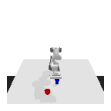

In [ ]:
obs = env.reset()
rgb, depth, mask, misc = env.render(mode = 'rgb_array')
display.HTML(display_anim([rgb['front']]));

### Basic example for "pick, place and pour"

We can now now explicitly generate a dataset. The below code is a (relatively naive) implementation of picking up the blue cup and putting it above (to the left) of the red one. In principle, one can append a pouring-action (e.g. by uncommenting some of the steps below), though it seems more efficient to train the model on pouring independently and then using the text-prompt in PerAct to combine the two.

In practice, I would propose to generate a dataset for the prompt "pick up the blue cup and move it close to the red one" and one for "pour x balls from the red cup into the blue one". Then train PerAct on this data and prompts and eventually test it on prompts such as "pick up the blue cup, move it close to the red one and pour x balls into it".

In any case, the interesting (and largely unexplored) part here is whether one can train PerAct to pour accurately a certain number of balls.

The approach in the below code is very naive by giving various points "waypoints" to approach and pick up the blue cup. I think it's worth investing some time to improve this and in particular add some diversity in the path, which will improve training.

In [ ]:
from matplotlib import pyplot as plt
from IPython import display

i=0
while i<20:
    obs = env.reset()
    og_ee_pos = env.robot.get_ee_position()
    ee_position = env.robot.get_ee_position()

    obs = []

    print('-----',i,'-----')
    goal = env.sim.get_base_position("object") - np.array([0.08,0.0,0])
    goal = np.concatenate((goal[:2],[og_ee_pos[2]]))

    obs+=(approach_target(goal, from_side = True, grip = 1, precision = 0.04))

    print('-----')
    goal = np.concatenate((goal[:2],[env.sim.get_base_position("object")[2]]))
    obs+=(approach_target(goal, from_side = True, grip = 1, precision = 0.04))

    print('-----')
    goal = env.sim.get_base_position("object") + np.array([0.04,0,0.0175])
    obs+=(approach_target(goal, from_side = True, grip = 0, precision = 0.01))

    print('-----')
    goal = goal+np.array([0,0,0.25])
    obs+=(approach_target(goal, from_side = True, grip = -1, precision = 0.04))

    #print('-----')
    #goal = env.sim.get_base_position("target") 
    #obs+=(approach_target(goal, from_side = True, grip = -1))

    print('-----')
    goal = env.sim.get_base_position("target") + np.array([0,0,0.16])
    #if goal[1]>env.sim.get_base_position("object")[1]:
    #  offset = np.array([0,-0.02,0])
    #  right = False 
    #else:
    #  offset = np.array([0,0.02,0])
    #  right = True 

    right = False
    offset = np.array([0,0.12,0])

    goal+=offset
    obs+=(approach_target(goal, from_side = True, grip = -1,precision = 0.001))

    print('-----')

    # if you want to include the pouring action:
    #obs+=pour(angle_shift=math.pi/2 + math.pi/2*(0.3),right = right)
    #print('-----')
    #obs+=pour(angle_shift=math.pi/2 + math.pi/8*(0.3),right = not right)

    #count nr in red, blue or spilled:
    #_,_,_,dd=count_nr_in_tg(env)
    #print(count_nr_in_tg(env)[:3])

    final_dist_= np.sqrt(distance(env.sim.get_base_position("target"),env.sim.get_base_position("object")))
    print(f'Final distance between blue and red cup: {final_dist_:.3f}m')
    print('visual check final frame:')
    fig = plt.figure()
    plt.imshow(obs[-1].front_rgb, interpolation='nearest')
    display.display(fig)

    panda_demo = Demo(obs)
    EPISODE_FOLDER = 'episode%d'
    index = i
    panda_dataset_dir_eps = os.path.join(panda_dataset_dir, EPISODE_FOLDER % index)
    if os.path.exists(panda_dataset_dir_eps):
      # be careful to remove potential previously stored demos for the next index
      !rm -rf $panda_dataset_dir_eps
      
    save_demo(panda_demo, panda_dataset_dir_eps)

    check_save = check_demo(panda_dataset_dir, index)
    if check_save:
      i+=1


Redo non-successful demos (upon checking the rendered final frames):

In [ ]:
redo_demos = [2,4,7,10,13,19]


i=redo_demos.pop()
while True:
    obs = env.reset()
    og_ee_pos = env.robot.get_ee_position()
    ee_position = env.robot.get_ee_position()

    obs = []

    print('-----',i,'-----')
    goal = env.sim.get_base_position("object") - np.array([0.08,0.0,0])
    goal = np.concatenate((goal[:2],[og_ee_pos[2]]))

    obs+=(approach_target(goal, from_side = True, grip = 1, precision = 0.04))

    print('-----')
    goal = np.concatenate((goal[:2],[env.sim.get_base_position("object")[2]]))
    obs+=(approach_target(goal, from_side = True, grip = 1, precision = 0.04))

    print('-----')
    goal = env.sim.get_base_position("object") + np.array([0.04,0,0.0175])
    obs+=(approach_target(goal, from_side = True, grip = 0, precision = 0.01))

    print('-----')
    goal = goal+np.array([0,0,0.25])
    obs+=(approach_target(goal, from_side = True, grip = -1, precision = 0.04))

    #print('-----')
    #goal = env.sim.get_base_position("target") 
    #obs+=(approach_target(goal, from_side = True, grip = -1))

    print('-----')
    goal = env.sim.get_base_position("target") + np.array([0,0,0.16])
    #if goal[1]>env.sim.get_base_position("object")[1]:
    #  offset = np.array([0,-0.02,0])
    #  right = False 
    #else:
    #  offset = np.array([0,0.02,0])
    #  right = True 

    right = False
    offset = np.array([0,0.12,0])

    goal+=offset
    obs+=(approach_target(goal, from_side = True, grip = -1,precision = 0.001))

    print('-----')

    # if you want to include the pouring action:
    #obs+=pour(angle_shift=math.pi/2 + math.pi/2*(0.3),right = right)
    #print('-----')
    #obs+=pour(angle_shift=math.pi/2 + math.pi/8*(0.3),right = not right)

    #count nr in red, blue or spilled:
    #_,_,_,dd=count_nr_in_tg(env)
    #print(count_nr_in_tg(env)[:3])

    final_dist_= np.sqrt(distance(env.sim.get_base_position("target"),env.sim.get_base_position("object")))
    print(f'Final distance between blue and red cup: {final_dist_:.3f}m')
    print('visual check final frame:')
    fig = plt.figure()
    plt.imshow(obs[-1].front_rgb, interpolation='nearest')
    display.display(fig)

    panda_demo = Demo(obs)
    EPISODE_FOLDER = 'episode%d'
    index = i
    panda_dataset_dir_eps = os.path.join(panda_dataset_dir, EPISODE_FOLDER % index)
    if os.path.exists(panda_dataset_dir_eps):
      !rm -rf $panda_dataset_dir_eps

    save_demo(panda_demo, panda_dataset_dir_eps)

    check_save = check_demo(panda_dataset_dir, index)
    if check_save:
      if redo_demos:
        i = redo_demos.pop()
      else:
        break

In [ ]:
!zip -r data_pnp.zip PyBulletPerAct/data

In [ ]:
from google.colab import files
files.download('data_pnp.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>